In [1]:
import numpy as np
from numpy.linalg import qr, svd, eig
from scipy.linalg import hadamard, subspace_angles

import jax
from jax import jit

import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.colors as colors

import imageio
import datetime

from kernel_sca import *
from utils import *

import wandb



In [2]:
X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/Churchland/churchland.npy')
d = 3
epsilon = 1e-3

X, _ = pre_processing(X_init, center=False, soft_normalize='max')
K, N, T = X.shape
A = jnp.swapaxes(pre_processing(X_init, center=False, soft_normalize='max')[0], 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

K_A_X = K_X_Y_identity(A, X)                                    #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)
K_A_A = K_A_A + (jnp.eye((K_A_A.shape[0])) * epsilon)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

#np.save('X_centerFalse_softNormMax', X)
#np.save('A_centerFalse_softNormMax', A)
#np.save('P_centerFalse_softNormMax', P)
#np.save('S_centerFalse_softNormMax', S)

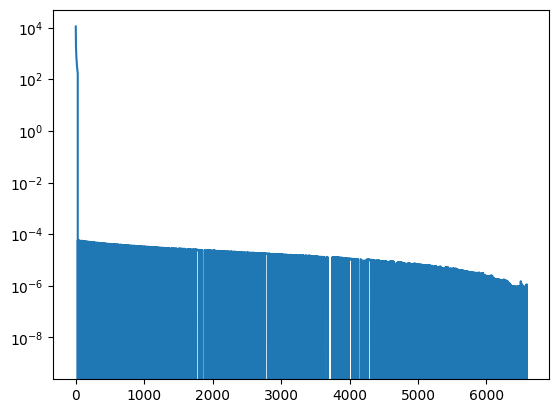

In [3]:
eigenvalues, eigenvectors = eig(K_A_A)

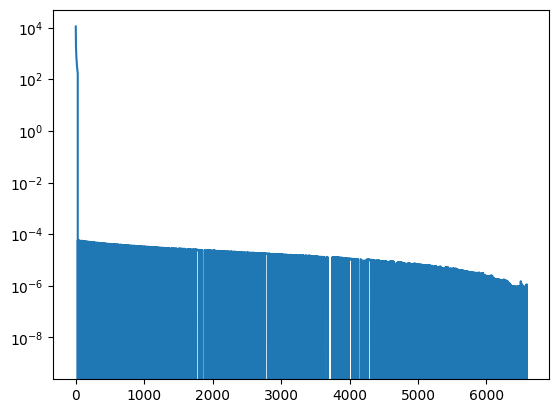

In [6]:
plt.semilogy(eigenvalues)

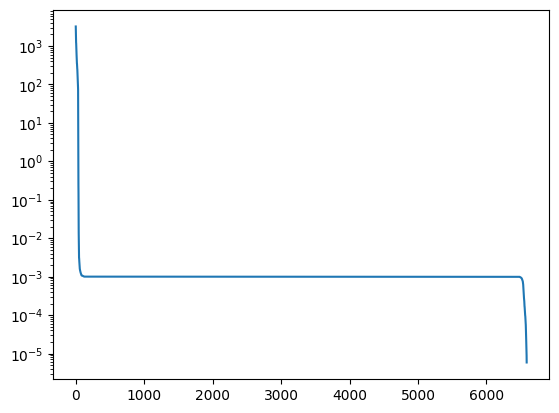

In [3]:
plt.semilogy(S)

In [ ]:
key = random.PRNGKey(42)
alpha = random.normal(key, (K*T, d))

alpha_prod = alpha.T @ alpha            #(d,d)
jnp.mean(( alpha_prod-jnp.identity(d,) )**2)

Array(14338793., dtype=float32)

In [ ]:

wandb.init(project="SCA-project-kernel", name="cpu_local", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X, iterations= 500, learning_rate= 0.01 )
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 0.006176508963108063, S_ratio: 0.04441770166158676
Iteration 10, S: 0.0318637490272522, S_ratio: 0.10649474710226059
Iteration 20, S: 0.09874318540096283, S_ratio: 0.138954758644104
Iteration 30, S: 0.30891597270965576, S_ratio: 0.1791023164987564
Iteration 40, S: 0.7048993110656738, S_ratio: 0.216884046792984
Iteration 50, S: 2.9401373863220215, S_ratio: 0.22015070915222168
Iteration 60, S: 7.723212242126465, S_ratio: 0.23420122265815735
Iteration 70, S: 23.035812377929688, S_ratio: 0.23501265048980713
Iteration 80, S: 39.53092956542969, S_ratio: 0.2839052975177765
Iteration 90, S: 67.7850570678711, S_ratio: 0.29467859864234924
Iteration 100, S: 131.3369903564453, S_ratio: 0.3028976023197174
Iteration 110, S: 121.51702117919922, S_ratio: 0.332775741815567
Iteration 120, S: 205.3209228515625, S_ratio: 0.31022119522094727
Iteration 130, S: 185.67857360839844, S_ratio: 0.32872116565704346
Iteration 140, S: 241.5670928955078, S_ratio: 0.3025469183921814
Iteration 150, S: 2

In [ ]:
np.save('alpha_tilde4', alpha_tilde)

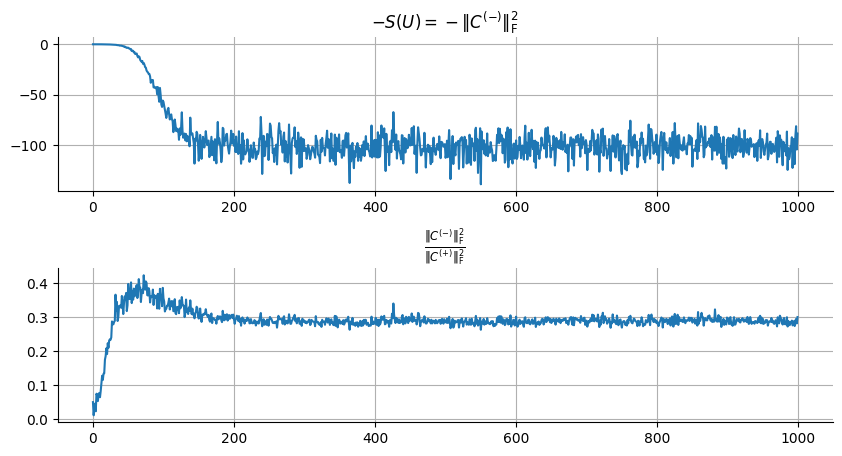

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

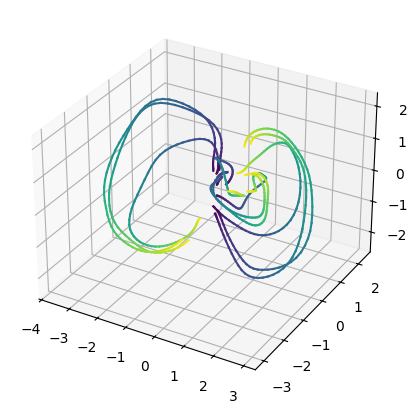

In [ ]:
#alpha_tilde = np.load("/Users/ariellerosinski/Desktop/a_500_clust_reorganised_loadX_2.npy")
#alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde)
alpha_tilde_QR, _ = qr_decomposition(alpha_tilde)
#alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * alpha_tilde_QR
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_3D(projection)

In [ ]:
U = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/optimized_U_linear_SCA/U_churchland_0.001_10000_3d.npy')
U_qr, _ = jnp.linalg.qr(U)
Y = jnp.einsum('ji,kjl->kil', U_qr, pre_processing(X_init, soft_normalize='max')[0])

Q_Y, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
Q_projection, _ = qr(projection.swapaxes(1,2).reshape(-1,d))
np.rad2deg(subspace_angles(Q_Y, Q_projection))[-1]


80.07225

In [ ]:
fig = go.Figure()
num_time_points = projection.shape[-1]
indices_to_plot = np.arange(0,projection.shape[0],1)

for i in indices_to_plot:
    x = projection[i, 0, :]
    y = projection[i, 1, :]
    z = projection[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))
fig.show()
